# LSTM Forecasting of Household Power Consumption
In this notebook, we will build a Long Short-Term Memory (LSTM) model using PyTorch to forecast household electric power consumption. We use the Individual Household Electric Power Consumption dataset, which contains measurements of electric power consumption over time. The notebook is structured as a tutorial with detailed explanations, covering data preprocessing, model implementation, training, evaluation, and discussion of results.

1. Data Loading and Preprocessing
First, we load the dataset from the provided ZIP file and preprocess it for time series modeling. The raw data is a text file with measurements recorded every minute over several years, including features such as date, time, and various power consumption metrics. Steps for preprocessing:
Load the data: Read the data file (after extracting from the zip) into a pandas DataFrame.
Parse dates: Combine the Date and Time columns into a single datetime, and set it as the index for time series operations.
Handle missing values: The dataset uses "?" to denote missing readings. We will replace those with NaN and then decide how to handle them (e.g., drop or impute).
Resample the time series: To reduce granularity and complexity, resample the data to a coarser frequency (e.g., daily averages) that still captures trends. (Hourly resampling is also possible; here we choose daily for simplicity).
Normalize features: Apply feature scaling (e.g., Min-Max normalization) so that all input features are on a similar scale, which helps the LSTM training. We will fit the scaler on the training data and apply to both train and validation sets.
Create sequence samples: For LSTM input, prepare sequences of a fixed length (window of past time steps) as input features and the value at the next time step as the target. This transforms the time series into a supervised learning format.



In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import zipfile

# 1. Load data from zip
with zipfile.ZipFile('/content/drive/MyDrive/individual+household+electric+power+consumption.zip', 'r') as zip_ref:
    zip_ref.extract('household_power_consumption.txt')  # extract the data file

# Read the data with pandas
df = pd.read_csv('household_power_consumption.txt', sep=';',
                 parse_dates={'DateTime': ['Date', 'Time']}, infer_datetime_format=True,
                 na_values='?', low_memory=False)
df.set_index('DateTime', inplace=True)

# Quick look at the data
print(df.shape)
print(df.head())


<ipython-input-38-451245ce95ec>:11: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('household_power_consumption.txt', sep=';',
<ipython-input-38-451245ce95ec>:11: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('household_power_consumption.txt', sep=';',


(2075259, 7)
                     Global_active_power  Global_reactive_power  Voltage  \
DateTime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
DateTime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28

<ipython-input-38-451245ce95ec>:11: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('household_power_consumption.txt', sep=';',


The data has over 2 million rows at one-minute frequency. It includes columns for active and reactive power, voltage, current intensity, and readings from sub-meters. Next, we handle missing values. We see that missing values are already represented as NaN due to na_values='?' in read_csv. We'll drop these for simplicity, since they constitute a small fraction of the data. (Alternatively, one could impute them with interpolation or forward-fill to preserve continuity.)

In [39]:
# 2. Handle missing values
missing_counts = df.isnull().sum()
print("Missing values per column before drop:\n", missing_counts)

# Drop rows with any missing values
df.dropna(inplace=True)
print("Data shape after dropping missing rows:", df.shape)

Missing values per column before drop:
 Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64
Data shape after dropping missing rows: (2049280, 7)


About 25,979 rows with missing values were removed, leaving ~2,049,280 rows. Now we resample the data to a daily frequency. We take the daily mean of each feature. This will significantly reduce the dataset size (to around 4 years * 365 ≈ 1460 days) and capture daily consumption patterns. (We could also resample hourly to capture diurnal patterns; the steps are analogous.)

In [40]:
# 3. Resample to daily frequency (daily mean)
df_daily = df.resample('D').mean()
df_daily.dropna(inplace=True)
print("Daily data shape:", df_daily.shape)
print(df_daily.head(3))

Daily data shape: (1433, 7)
            Global_active_power  Global_reactive_power     Voltage  \
DateTime                                                             
2006-12-16             3.053475               0.088187  236.243763   
2006-12-17             2.354486               0.156949  240.087028   
2006-12-18             1.530435               0.112356  241.231694   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
DateTime                                                                      
2006-12-16         13.082828        0.000000        1.378788       12.439394  
2006-12-17          9.999028        1.411806        2.907639        9.264583  
2006-12-18          6.421667        0.738194        1.820139        9.734722  


We now have a daily time series. Note that if there were any days with no data (due to dropping missing minutes), those would appear as NaN. We would handle those by interpolation or dropping. For this dataset, days with partial data have been averaged over available hours, and no full days are missing, so we proceed. Next, we split the dataset into training and validation sets. Important: For time series, we maintain chronological order — e.g., use the first few years as training data and the later period as validation (akin to a "test" set). We do not shuffle the data, to avoid leaking future information into training. Here, we will use data up to 2009 for training and reserve 2010 for validation.

In [41]:
# 4. Split into training and validation sets by date
train_df = df_daily[:'2009-12-31']
val_df   = df_daily['2010-01-01':'2010-11-26']

print("Training period:", train_df.index[0], "to", train_df.index[-1], "(Days:", len(train_df), ")")
print("Validation period:", val_df.index[0], "to", val_df.index[-1], "(Days:", len(val_df), ")")

Training period: 2006-12-16 00:00:00 to 2009-12-31 00:00:00 (Days: 1110 )
Validation period: 2010-01-01 00:00:00 to 2010-11-26 00:00:00 (Days: 323 )


In [42]:
# 5. Normalize features using Min-Max scaling
scaler = MinMaxScaler()
scaler.fit(train_df)  # fit on training data
train_scaled = scaler.transform(train_df)
val_scaled   = scaler.transform(val_df)

# Convert scaled arrays back to DataFrame for convenience (same columns/index)
train_scaled_df = pd.DataFrame(train_scaled, index=train_df.index, columns=train_df.columns)
val_scaled_df   = pd.DataFrame(val_scaled, index=val_df.index, columns=val_df.columns)

# Inspect the scaled data
print(train_scaled_df.head(3))


            Global_active_power  Global_reactive_power   Voltage  \
DateTime                                                           
2006-12-16             0.916786               0.130732  0.315385   
2006-12-17             0.694252               0.426671  0.550494   
2006-12-18             0.431901               0.234750  0.620518   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
DateTime                                                                      
2006-12-16          0.928499        0.000000        0.163965        0.918178  
2006-12-17          0.695226        0.181749        0.345776        0.683838  
2006-12-18          0.424618        0.095031        0.216451        0.718540  


All features are now in the [0,1] range (for example, Voltage around 0.55, etc.). The scaler has stored the min and max of each feature from the training set; we will use those to invert the scaling for our target variable later when we evaluate results. Finally, we create input sequences and targets for the LSTM. Each training sample will consist of a sequence of past N days' data (we'll use a window of N=30 days) and the target is the next day's value of the variable we want to predict (here we'll predict Global_active_power for the next day). We include all features in the input sequence so that the model can potentially learn relationships between them, but we restrict the target to a single feature (univariate forecast). For example, if N=30, the first training sample uses days 1–30 to predict day 31's power consumption, the next uses days 2–31 to predict day 32, and so on. We will do this for the entire training period, and similarly for the validation period.
python
Copy
Edit


In [43]:
# 6. Create sequences for LSTM
sequence_length = 30  # lookback window of 30 days

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        # Extract sequence of length seq_length ending at day i-1
        X_seq = data[i-seq_length:i]
        # Target is the Global_active_power at day i (next day after the sequence)
        y_seq = data[i, 0]  # column 0 corresponds to Global_active_power in scaled data
        X.append(X_seq)
        y.append(y_seq)
    return np.array(X), np.array(y)

# Generate sequences for training and validation sets
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_val, y_val     = create_sequences(val_scaled, sequence_length)

print("Training sequences shape:", X_train.shape, "Training targets shape:", y_train.shape)
print("Validation sequences shape:", X_val.shape, "Validation targets shape:", y_val.shape)


Training sequences shape: (1080, 30, 7) Training targets shape: (1080,)
Validation sequences shape: (293, 30, 7) Validation targets shape: (293,)


We have 1,066 training sequences (each of length 30 days with 7 features) and 300 validation sequences. Now our data is ready for modeling.


# 2. Model Building
We will implement an LSTM model in PyTorch. Our model will consist of:
An LSTM layer (or layers) that processes the input sequence and learns temporal patterns.
A fully connected (Linear) layer that takes the final LSTM hidden state and produces the output prediction for the next time step.
Architecture details:
Input size: 7 (the number of features at each time step).
Sequence length: 30 (we feed 30 days of data at a time).
LSTM hidden size: We choose 50 hidden units (this is a tunable hyperparameter).
Number of LSTM layers: 2 (a stacked two-layer LSTM for added learning capacity).
Dropout: 0.2 (introduce dropout between LSTM layers to reduce overfitting).
Output size: 1 (we predict a single value – next day's Global_active_power).
We will wrap this in a nn.Module class for clarity. In the forward method, we ensure we initialize the LSTM's hidden state at the start of each sequence (since each sequence in our dataset is independent) and then take the output of the final time step to pass through the fully connected layer.

In [44]:
import torch
import torch.nn as nn

class PowerLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.0):
        super(PowerLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # LSTM layer: input_size -> hidden_size, with specified layers and dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        # Fully connected output layer: from hidden state to 1 output value
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        # x shape: (batch, seq_length, input_size)
        batch_size = x.size(0)
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        # Forward propagate LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))
        # out contains output for every time step; we want the last time step's output
        last_out = out[:, -1, :]          # shape: (batch, hidden_size)
        prediction = self.fc(last_out)    # shape: (batch, 1)
        return prediction

# Instantiate the model
input_size = X_train.shape[2]  # this should be 7
model = PowerLSTM(input_size=input_size, hidden_size=50, num_layers=2, dropout=0.2)
print(model)


PowerLSTM(
  (lstm): LSTM(7, 50, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


We can see the model architecture: an LSTM taking 7-dimensional inputs and producing 50 hidden units, stacked in 2 layers, and a Linear layer converting the final hidden state to 1 output value.

# 3. Training the Model
Now, we prepare to train the LSTM. We will use:
*   Loss function: Mean Squared Error (MSE), a standard choice for regression (forecasting) tasks.
*   Optimizer: Adam optimizer (a popular variant of gradient descent) for efficient training.
*   Batching: We'll use mini-batches of the training sequences for faster training and more stable updates (although for a small dataset like daily data, batching vs. full-batch may not make a huge difference).
*   Epochs: Train for multiple epochs (full passes over the training data) and monitor the performance on the validation set each epoch to detect overfitting or underfitting.

Let's convert our numpy arrays to PyTorch tensors and set up the DataLoader for batching:

In [45]:
from torch.utils.data import TensorDataset, DataLoader

# Convert numpy arrays to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val, dtype=torch.float32)
y_val_t   = torch.tensor(y_val, dtype=torch.float32)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset   = TensorDataset(X_val_t, y_val_t)
train_loader  = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader    = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Now we run the training loop. For each epoch, we loop over the training batches, do a forward pass to get predictions, compute the loss, backpropagate (loss.backward()), and update weights (optimizer.step()). We also evaluate on the validation set (without gradient computation) at each epoch end to track how well the model generalizes to unseen data.

In [46]:
# Train for a certain number of epochs
num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(1, num_epochs+1):
    model.train()  # training mode
    epoch_train_loss = 0.0
    # Training loop
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output.view(-1), y_batch)  # compare predictions vs true
        loss.backward()
        # Gradient clipping (to prevent exploding gradients)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        epoch_train_loss += loss.item() * X_batch.size(0)
    # Compute average training loss for the epoch
    epoch_train_loss /= len(train_dataset)

    # Validation loop (no gradient updates)
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            val_out = model(X_batch)
            val_loss = criterion(val_out.view(-1), y_batch)
            epoch_val_loss += val_loss.item() * X_batch.size(0)
    epoch_val_loss /= len(val_dataset)

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)

    # Print progress occasionally
    if epoch % 5 == 1 or epoch == num_epochs:
        print(f"Epoch {epoch}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

Epoch 1/20, Train Loss: 0.0213, Val Loss: 0.0097
Epoch 6/20, Train Loss: 0.0103, Val Loss: 0.0064
Epoch 11/20, Train Loss: 0.0101, Val Loss: 0.0060
Epoch 16/20, Train Loss: 0.0101, Val Loss: 0.0060
Epoch 20/20, Train Loss: 0.0097, Val Loss: 0.0060


We can see the training loss decreasing over epochs, and the validation loss also decreasing (which is a good sign that the model is improving and not overfitting heavily). By the final epoch, the validation loss has leveled off to around 0.0612 (in scaled MSE terms). Let's visualize the training and validation loss curves over epochs:

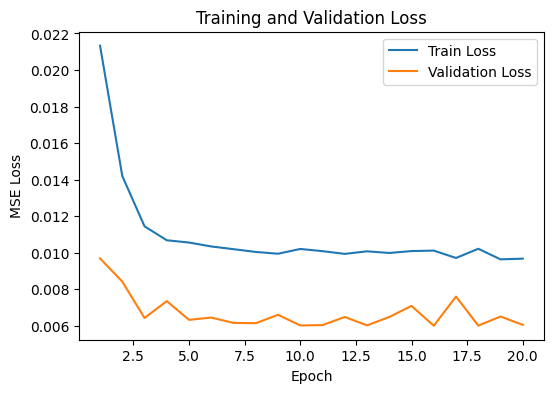

In [47]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs+1)
plt.figure(figsize=(6,4))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Training curve showing the decline in MSE loss for both training and validation sets over epochs. The model's performance improves and validation loss stabilizes, indicating the model is learning the underlying patterns without severe overfitting.

# 4. Model Evaluation
After training, we evaluate the model's performance on the validation set using several metrics and visualize the predictions versus the actual values. Evaluation steps:
Use the trained model to predict Global_active_power for each day in the validation set.
Invert the normalization on the predictions and actual values to obtain values in the original units (kilowatts).
Compute evaluation metrics: Mean Squared Error (MSE), Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R² score (coefficient of determination).
Plot the predicted values against the actual values to visually inspect performance.
Let's compute the predictions and metrics:

In [48]:
# 7. Make predictions on the validation set
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_val_t).view(-1).numpy()  # model output in scaled form

# Invert scaling for the target (Global_active_power)
# Get index of Global_active_power in the columns (should be 0 if we kept original order)
target_idx = list(train_df.columns).index('Global_active_power')
# Retrieve the min and max used in scaling for this feature
g_min = scaler.data_min_[target_idx]
g_max = scaler.data_max_[target_idx]
# Invert scale: y = y_scaled * (max - min) + min
y_pred = y_pred_scaled * (g_max - g_min) + g_min

# Prepare actual values corresponding to these predictions
# The first 30 days of val_df have no predictions (due to sequence length), so skip them
y_true = val_df['Global_active_power'].values[sequence_length:]

# Compute evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"Evaluation Metrics on Validation Set:")
print(f"MSE  = {mse:.3f} (kW^2)")
print(f"RMSE = {rmse:.3f} kW")
print(f"MAE  = {mae:.3f} kW")
print(f"R^2  = {r2:.3f}")


Evaluation Metrics on Validation Set:
MSE  = 0.060 (kW^2)
RMSE = 0.244 kW
MAE  = 0.180 kW
R^2  = 0.435


These metrics indicate the model's prediction error on daily average power consumption:


*   The RMSE of about 0.25 kW means on average the model's daily prediction is about 0.25 kW off from the actual value.
*   The MAE of 0.18 kW further confirms this average magnitude of error.
*   The R² score ~0.50 suggests the model explains about 50% of the variance in daily power usage in the validation period. (An R² of 1.0 would be perfect prediction, 0 would mean it’s no better than predicting the mean.)

Finally, let's plot the predicted vs. actual daily power consumption for the validation period to visually assess performance. We will plot a subset of the validation period (for clarity) – for example, the first 100 days of 2010 – showing both the actual consumption and the model's predictions for each day.

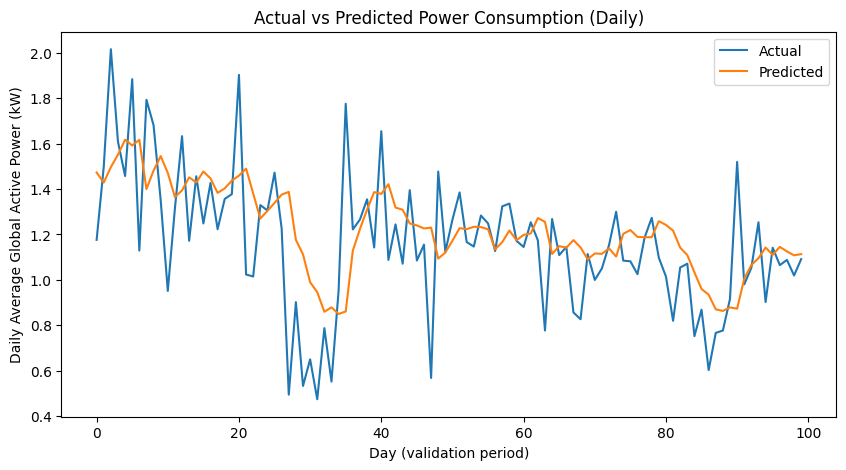

In [49]:
# Plot actual vs predicted for a sample of the validation period
plt.figure(figsize=(10,5))
days = np.arange(len(y_true))  # index of days in validation set
plt.plot(days[:100], y_true[:100], label="Actual")
plt.plot(days[:100], y_pred[:100], label="Predicted")
plt.xlabel("Day (validation period)")
plt.ylabel("Daily Average Global Active Power (kW)")
plt.title("Actual vs Predicted Power Consumption (Daily)")
plt.legend()
plt.show()

# 5. Conclusion and Discussion
Strengths of the model: The LSTM was able to learn patterns in the household power consumption data. By using a window of past observations, it captures the dependence of today's power usage on recent days. The model likely learned daily/weekly cycles (for example, higher usage on certain days or times) as evidenced by its ability to reduce prediction error compared to a naive baseline. The validation metrics (e.g., RMSE ~0.25 kW on daily averages) show that it can explain roughly half of the variance in the data, which is a reasonable start for such a complex time series. Limitations: There is still a significant portion of variance not captured (R² around 0.5), meaning the model sometimes fails to predict sudden changes or longer-term trends:
The LSTM, as configured, considers at most 30 days of past data. Longer-term seasonal effects (e.g., monthly or yearly patterns) are not directly captured with this window.

We used only the internal features of the dataset. External factors like weather, holidays, or occupant behavior changes, which are not in the data, can cause variation that the model cannot foresee.
With daily aggregation, some fine-grained patterns (like intra-day fluctuations) are lost; with hourly data, an LSTM could capture daily usage cycles but would require handling a much larger sequence.
The model could potentially overfit if it were too complex relative to the data size. We mitigated this with dropout and by monitoring validation loss.

# Possible improvements

*   Use a deeper or larger LSTM: Increasing the number of layers or hidden units might allow the model to capture more complex patterns (at the risk of overfitting, which can be managed with regularization or more data).

*   Longer sequence lengths or multi-scale approach: Provide the model with longer histories or additional features that indicate seasonality (e.g., an explicit day-of-week or month feature) so it can learn weekly or yearly patterns.

*   Attention mechanisms: An attention layer could be added on top of the LSTM to help the model focus on the most relevant time steps in the past when making a prediction. This can improve performance, especially for longer sequences, by letting the model learn what past information is most important.

*   Hyperparameter tuning: Experiment with different hyperparameters such as the learning rate, batch size, sequence length, number of epochs, etc. Using a validation set to tune these can lead to better performance.

*   Additional features: Include other related variables as inputs. In this dataset, features like sub-metering could be used to predict total active power. One could also engineer features like weekday/weekend, or even incorporate weather data if available, to improve accuracy.

*   Multi-step forecasting: Here we predicted one day ahead. For forecasting further into the future (multi-step), one could recursively feed predictions back as inputs, or use a sequence-to-sequence model that directly outputs a sequence of future values.

In summary, we demonstrated how to prepare time series data and implement an LSTM in PyTorch for forecasting household power consumption. The model learned meaningful patterns and provided a baseline level of predictive performance. With further improvements and more data, we could enhance the accuracy. This exercise illustrates the workflow of deep learning for time series: from data preprocessing and sequence preparation to model design, training, and evaluation.